# **Analisis Time Series**

Persiapan Environment

In [34]:
import time
start_time = time.time()

In [35]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.rolling import RollingOLS

from prophet import Prophet
import prophet
import sklearn
import statsmodels

import tensorflow

In [36]:
# Print Python version
print("Python version:", sys.version)

# Print versions of each package
print("pandas version:", pd.__version__)
print("matplotlib version:", matplotlib.__version__)
print("numpy version:", np.__version__)
print("prophet version:", prophet.__version__)
print("sklearn version:", sklearn.__version__)
print("seaborn version:", sns.__version__)
print("statsmodel version:", statsmodels.__version__)
print("tensorflow version:", tensorflow.__version__)

Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
pandas version: 2.1.2
matplotlib version: 3.8.2
numpy version: 1.26.1
prophet version: 1.1.5
sklearn version: 1.3.2
seaborn version: 0.13.2
statsmodel version: 0.14.2
tensorflow version: 2.17.0


In [37]:
import json

config = {
    "python_version": "3.11.9",
    "libraries": {
        "pandas": "2.1.2",
        "matplotlib": "3.8.2",
        "numpy": "1.26.1",
        "prophet": "1.1.5",
        "sklearn": "1.3.2",
        "seaborn": "0.13.2",
        "statsmodels": "0.14.2",
        "tensorflow": "2.17.0"
    }
}

with open('config.json', 'w') as config_file:
    json.dump(config, config_file, indent=4)

print("Configuration file 'config.json' created successfully.")

Configuration file 'config.json' created successfully.


### Prepare All Dataset Used and Integrate it

In [38]:
sys.path.append(os.path.join(os.getcwd(), 'script'))
from data_loader import load_dataset

dir_path = 'data'
for filename in os.listdir(dir_path):
  if filename.endswith('.csv'):
    file_path = os.path.join(dir_path, filename)

    df_name = filename[:-4]
    globals()[df_name] = pd.read_csv(file_path, delimiter=';')


data_list  =  [
    'jumlah_perjalanan_mrt',
    'jumlah_perjalanan_lrt',
    'jumlah_armada_tj',
    'jumlah_penumpang_lrt',
    'jumlah_penumpang_mrt',
    'training_jumlah_penumpang_tj'
]

data_all= load_dataset(dir_path, data_list)
data_all.to_csv('output/data_all.csv', index=False)

In [39]:
data_all = data_all.rename(columns={'tahun': 'year', 'bulan': 'month', 'training_jumlah_penumpang_tj':'jumlah_penumpang'})
data_all['date'] = pd.to_datetime(data_all[['year', 'month']].assign(day=1))
data_all.set_index('date', inplace=True)
data_all = data_all.drop(columns=['year','month'])
data_all.head()

,jumlah_perjalanan_mrt,jumlah_perjalanan_lrt,jumlah_armada_tj,jumlah_penumpang_lrt,jumlah_penumpang_mrt,jumlah_penumpang
date,,,,,,
2023-01-01,8035.0,6190.0,3853.0,72424.0,2540315.0,20001303.0
2023-02-01,7340.0,5980.0,3864.0,76166.0,2378568.0,18710281.0
2023-03-01,8035.0,6200.0,3890.0,82754.0,2699585.0,21046680.0
2023-04-01,7270.0,5998.0,3853.0,72318.0,2065546.0,16686971.0
2023-05-01,8161.0,6198.0,3944.0,78639.0,2681876.0,22845144.0


In [40]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113 entries, 2023-01-01 to 2022-12-01
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   jumlah_perjalanan_mrt  17 non-null     float64
 1   jumlah_perjalanan_lrt  17 non-null     float64
 2   jumlah_armada_tj       17 non-null     float64
 3   jumlah_penumpang_lrt   17 non-null     float64
 4   jumlah_penumpang_mrt   17 non-null     float64
 5   jumlah_penumpang       108 non-null    float64
dtypes: float64(6)
memory usage: 6.2 KB


# **Eksplorasi Data Analisis**

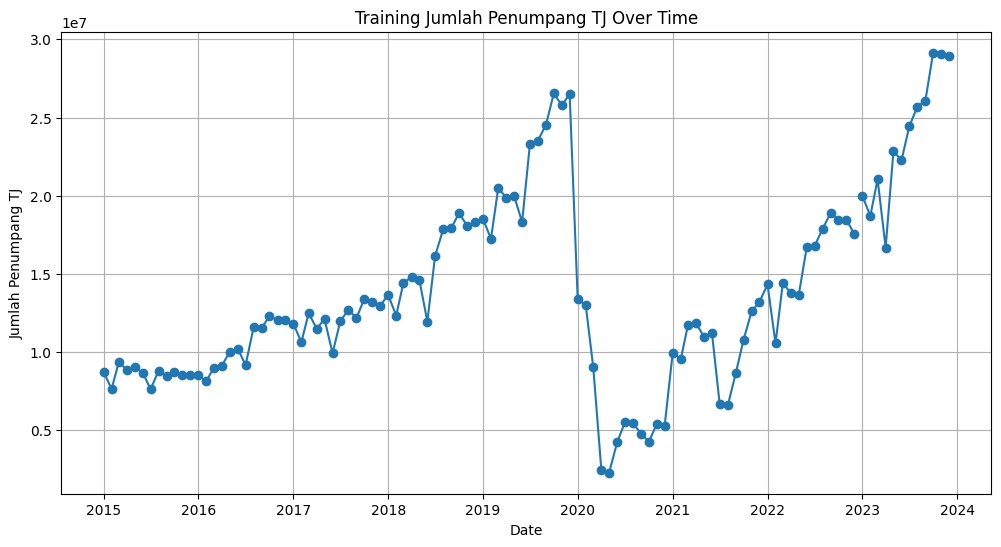

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(data_all['jumlah_penumpang'], marker='o')
plt.title('Training Jumlah Penumpang TJ Over Time')
plt.xlabel('Date')
plt.ylabel('Jumlah Penumpang TJ')
plt.grid(True)
plt.show()

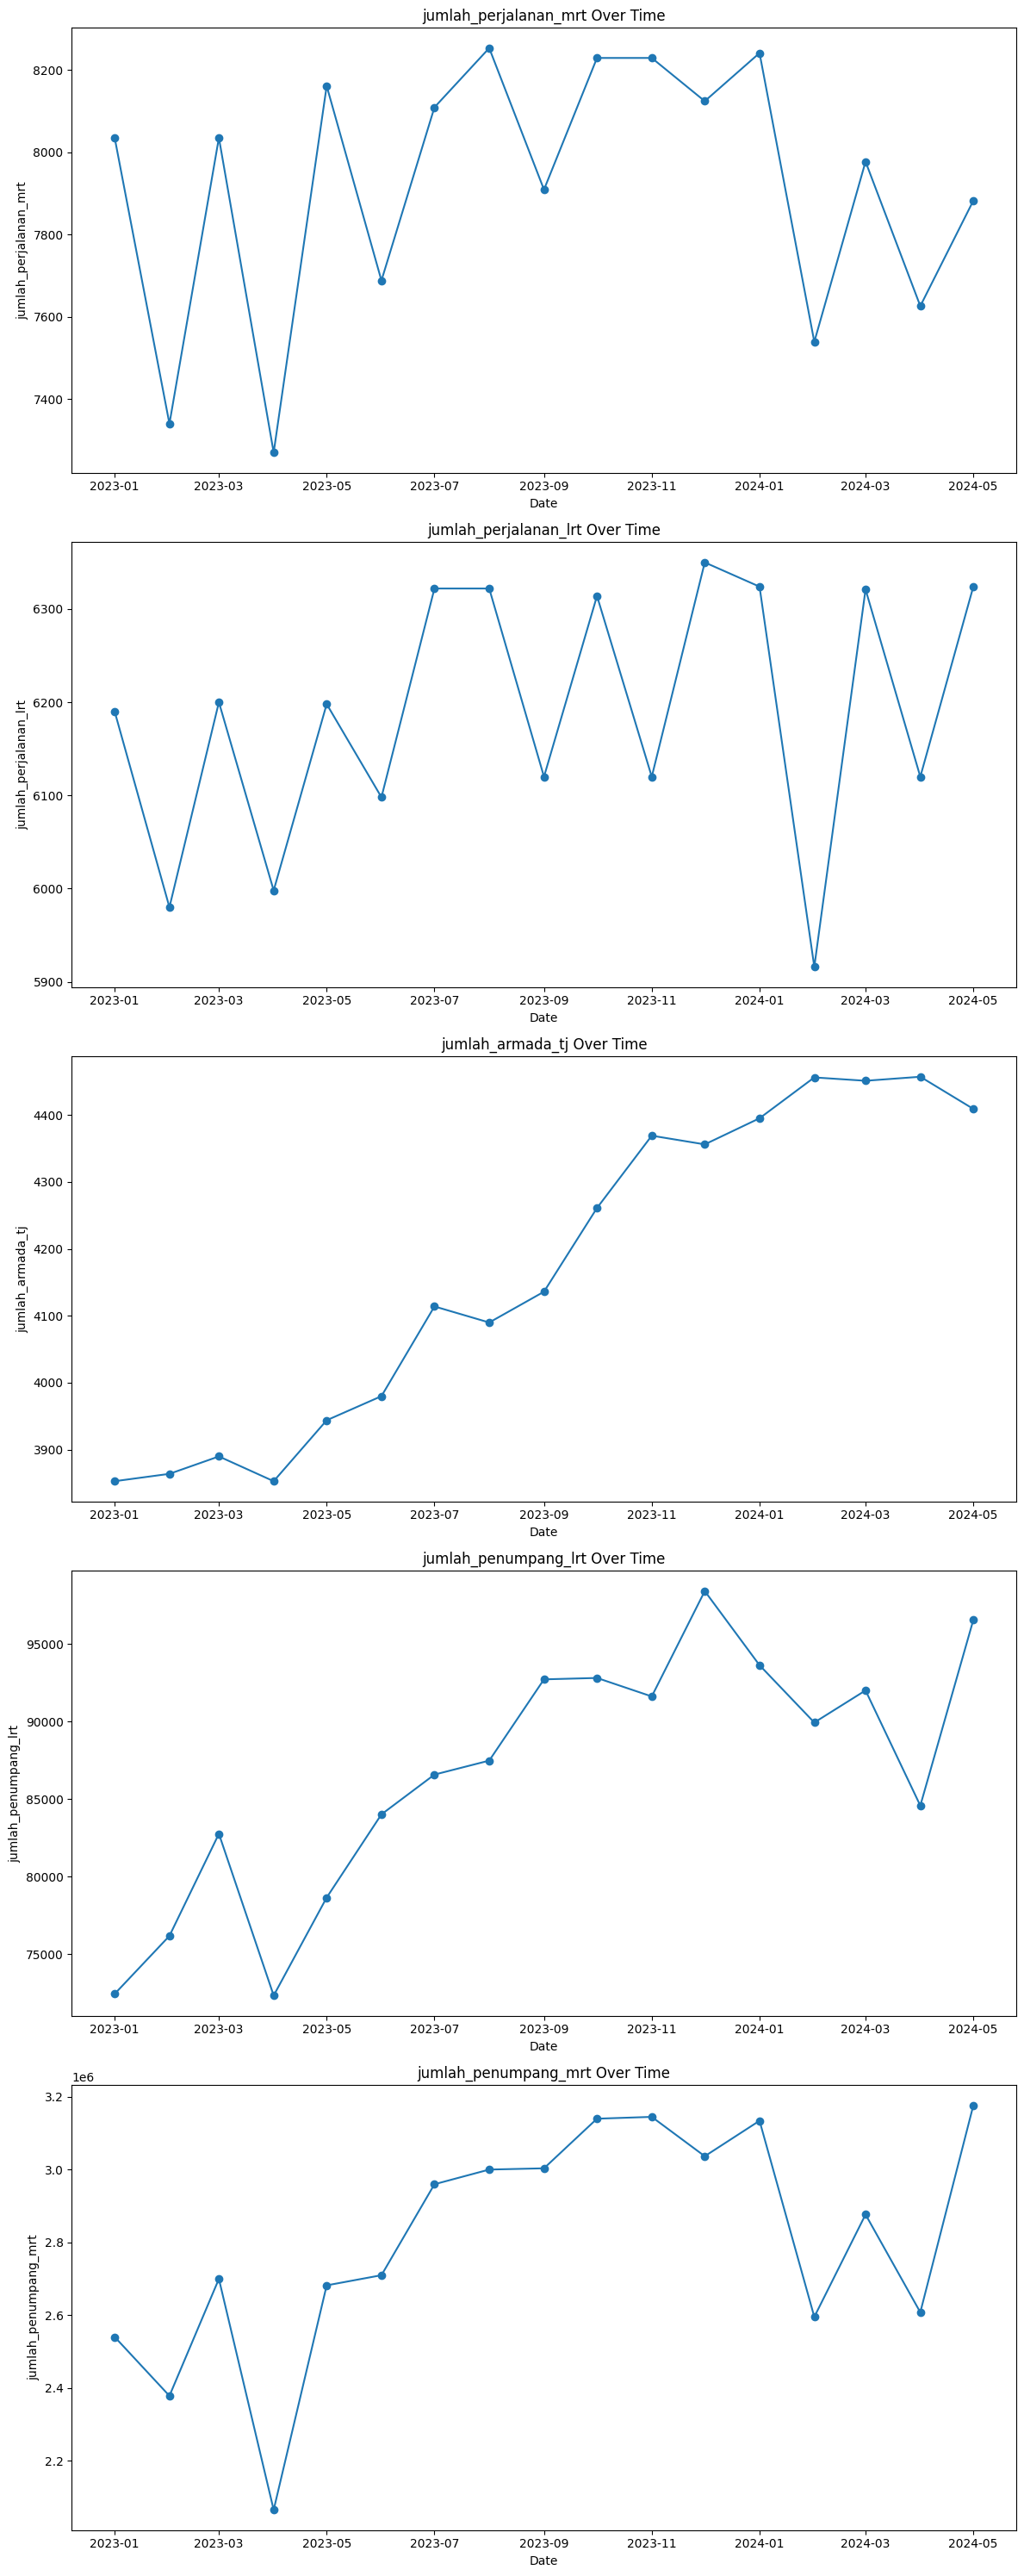

In [42]:
columns_to_plot = [col for col in data_all.columns if col != 'jumlah_penumpang']

fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(12, 6*len(columns_to_plot)))

for i, col in enumerate(columns_to_plot):
  axes[i].plot(data_all[col], marker='o')
  axes[i].set_title(f'{col} Over Time')
  axes[i].set_xlabel('Date')
  axes[i].set_ylabel(col)
  axes[i].grid(False)

plt.tight_layout()
plt.show()

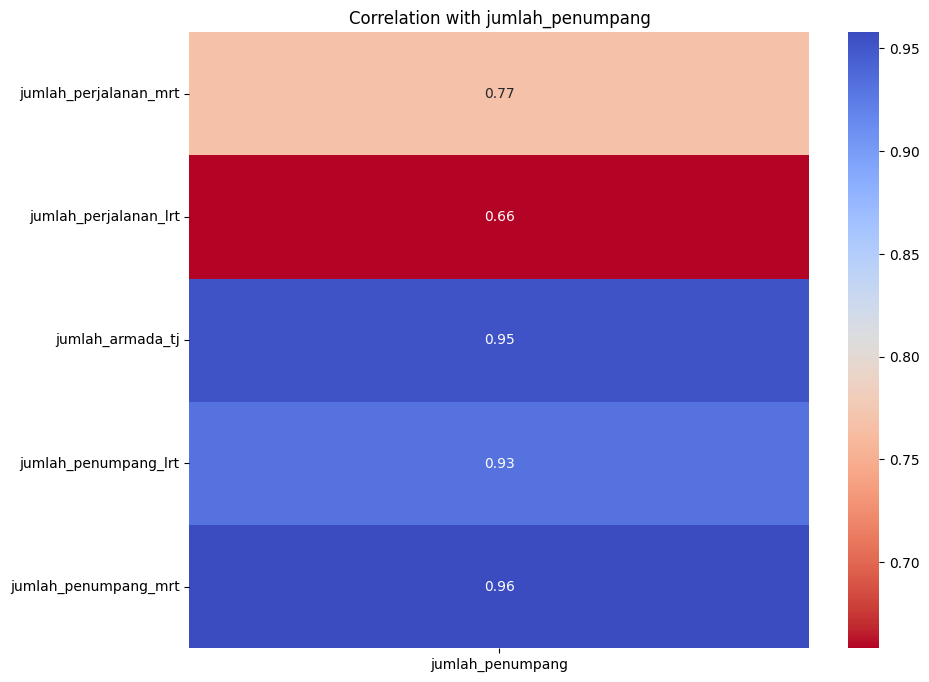

In [43]:
data_cleaned = data_all.dropna(subset=['jumlah_penumpang'])

corr_matrix = data_cleaned.corr()
corr_with_target = corr_matrix['jumlah_penumpang']
corr_with_target = corr_with_target.drop('jumlah_penumpang')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm_r', fmt=".2f")
plt.title('Correlation with jumlah_penumpang')
plt.show()

From the correlation plot, we know that 'jumlah_penumpang_mrt', 'jumlah_penumpang_lrt', and 'jumlah_armada_tj' have a high correlation with 'jumlah_penumpang_transjakarta'. This means that these three variables are potential candidates to be used as corrections for the main time series model.

# **Modeling Machine Learning**

Using neural networks for time series analysis involves leveraging the capabilities of artificial neural networks (ANNs) to model and predict patterns within sequential data. Time series data is a collection of observations or measurements taken over time, such as stock prices, temperature readings, or sensor data.

General Workflow of Time Series Forecasting Using Neural Networks:

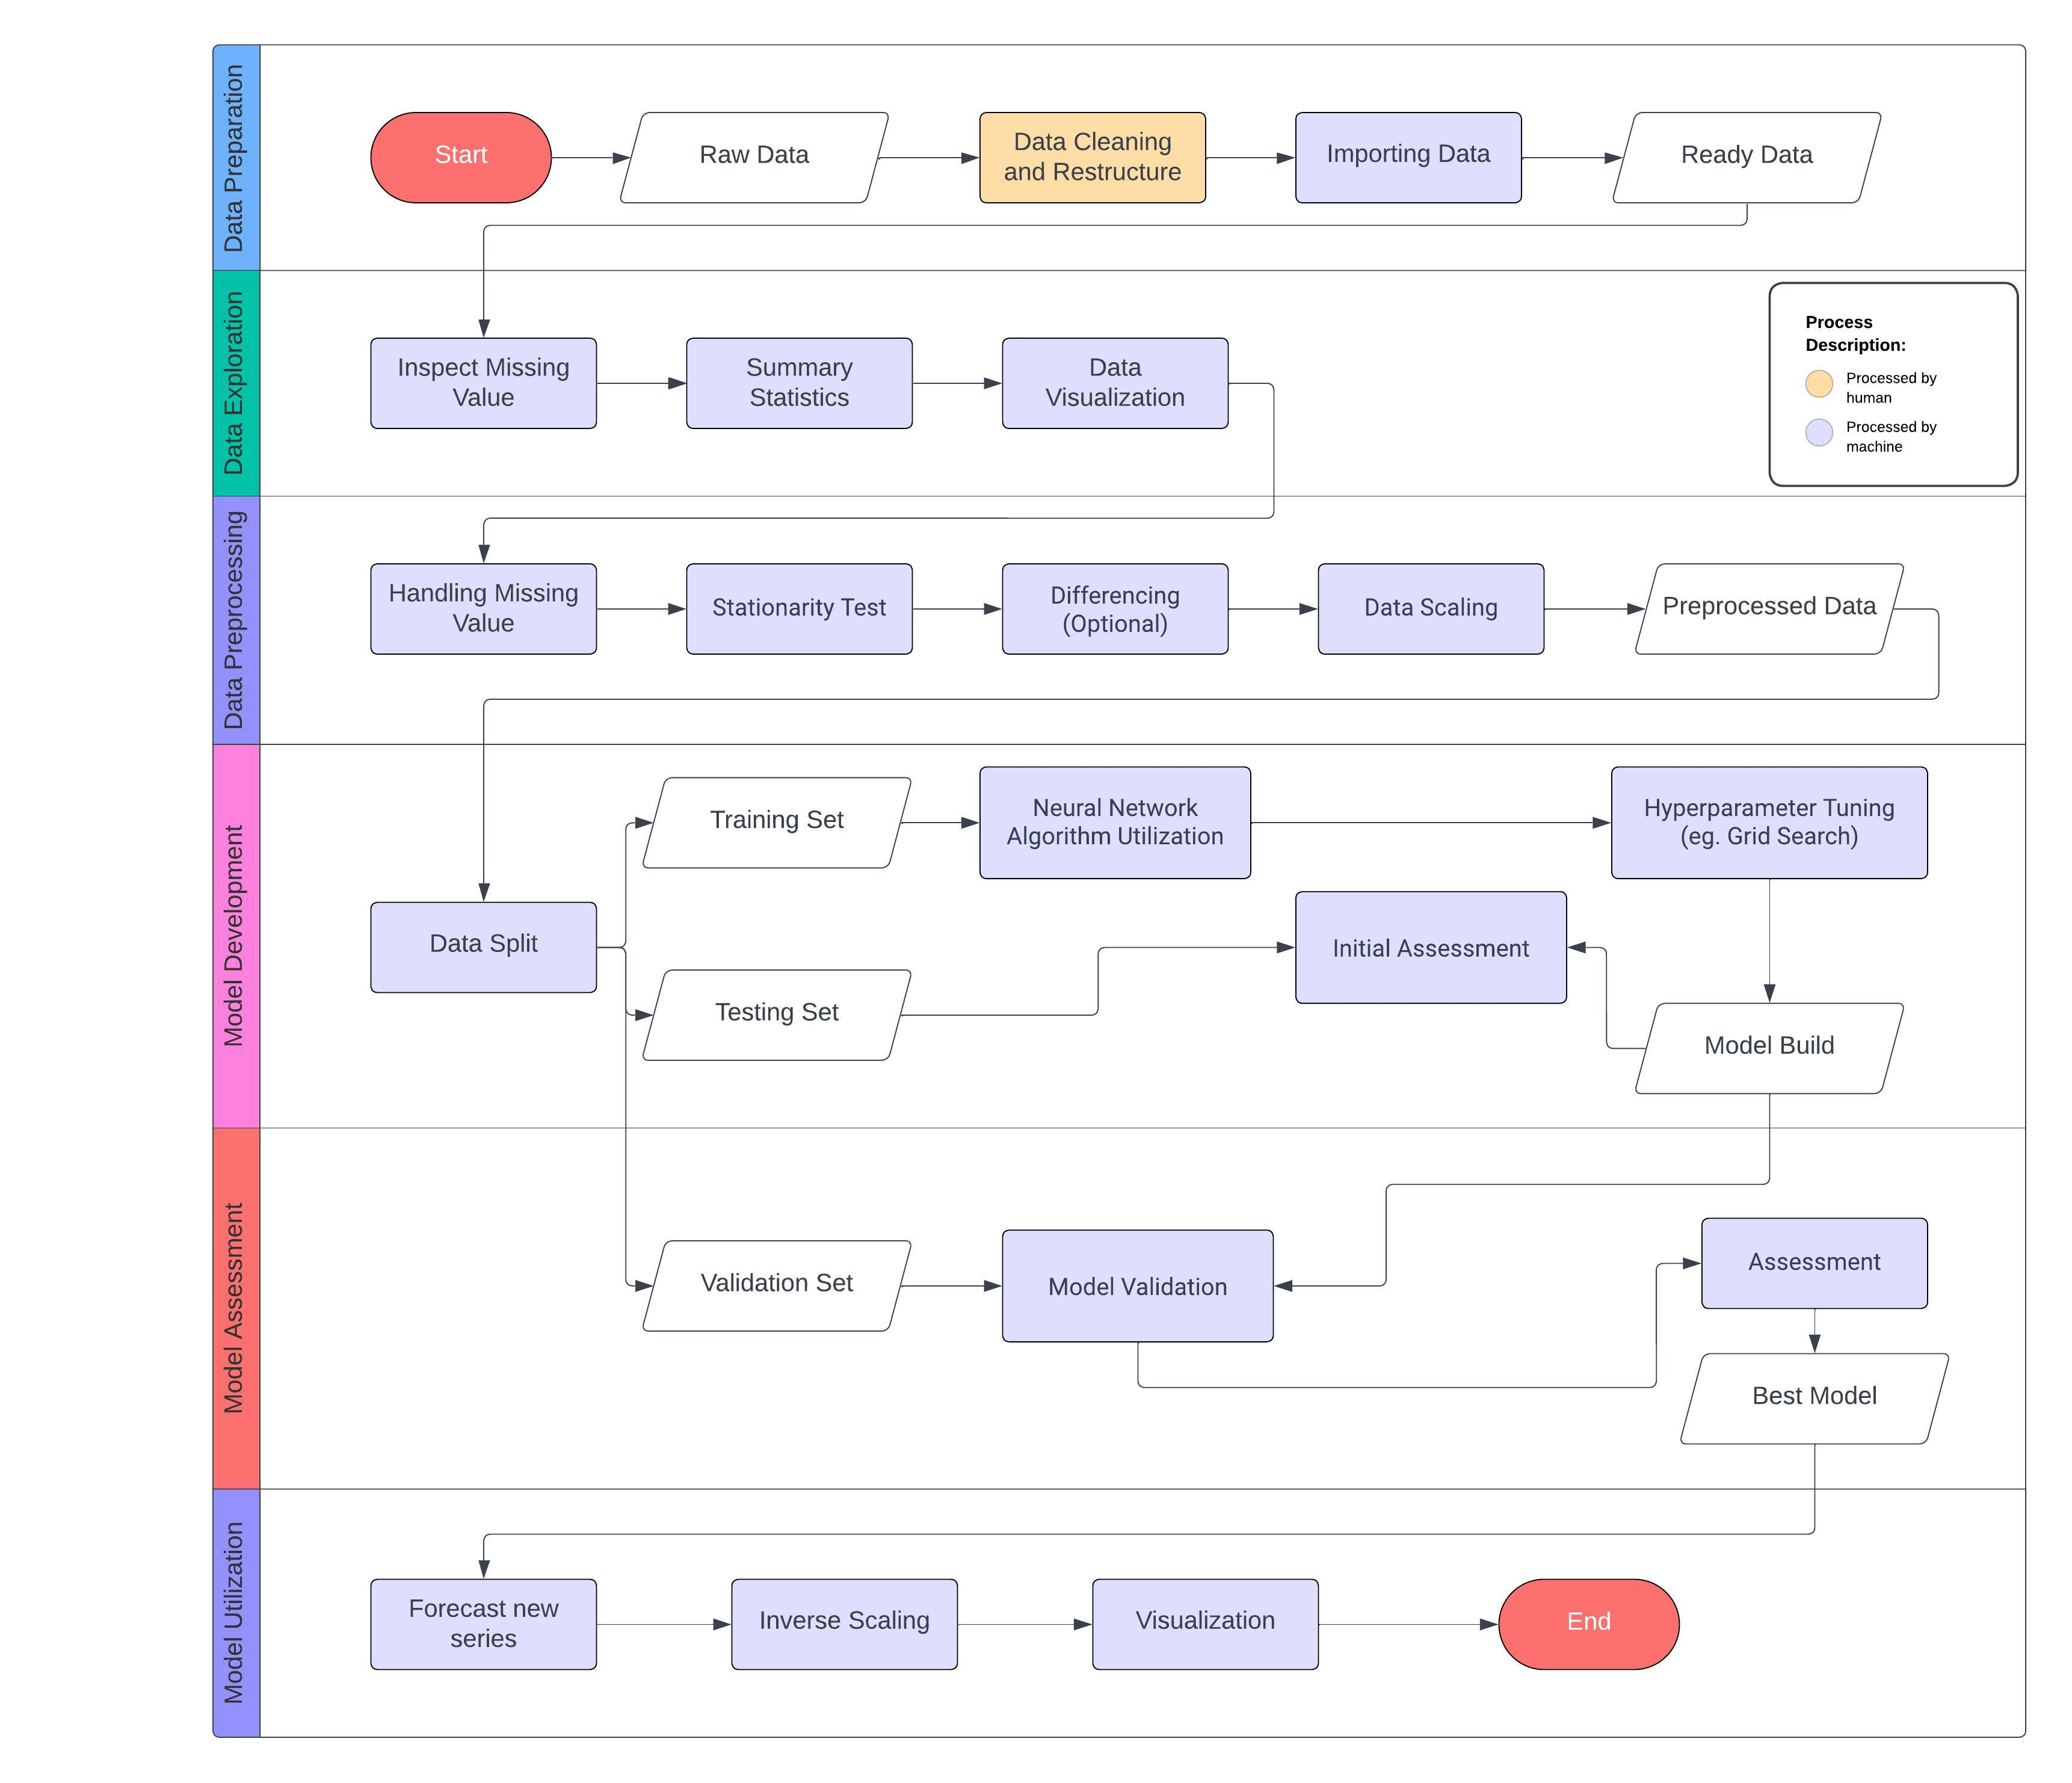

In [44]:
data = pd.DataFrame(data_all.jumlah_penumpang)
data = data.dropna()
data.head()

,jumlah_penumpang
date,
2023-01-01,20001303.0
2023-02-01,18710281.0
2023-03-01,21046680.0
2023-04-01,16686971.0
2023-05-01,22845144.0


In [45]:
sys.path.append(os.path.join(os.getcwd(), 'script'))
from modeling_simple import generate_ar_ma_dataframe
from modeling_simple import split_train_test
from modeling_simple import evaluation_measure
from modeling_simple import evaluate_model
from modeling_simple import build_rnn_model
from modeling_simple import build_lstm_model
from modeling_simple import evaluation_all
from modeling_simple import forecast_new

In [46]:
data_clean = generate_ar_ma_dataframe(data.jumlah_penumpang, 7, 0, 3, 0)
data_clean.head()

,target,AR(1),AR(2),AR(3),AR(4),AR(5),AR(6),AR(7),MA(3)
date,,,,,,,,,
2023-08-01,25693459.0,24428349.0,22264954.0,22845144.0,16686971.0,21046680.0,18710281.0,20001303.0,2.412892e+07
2023-09-01,26076085.0,25693459.0,24428349.0,22264954.0,22845144.0,16686971.0,21046680.0,18710281.0,2.539930e+07
2023-10-01,29146729.0,26076085.0,25693459.0,24428349.0,22264954.0,22845144.0,16686971.0,21046680.0,2.697209e+07
2023-11-01,29062581.0,29146729.0,26076085.0,25693459.0,24428349.0,22264954.0,22845144.0,16686971.0,2.809513e+07
2023-12-01,28957580.0,29062581.0,29146729.0,26076085.0,25693459.0,24428349.0,22264954.0,22845144.0,2.905563e+07


In [47]:
X_train, X_test, y_train, y_test, train_dates, test_dates = split_train_test(data_clean, ['target'])

# Convert dataframes to numpy arrays
X_train_array = X_train.values
X_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values

In [48]:
# Support Vector Regression with GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]}
svm_model = GridSearchCV(SVR(), param_grid=svm_param_grid, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5))
svm_model = svm_model.fit(X_train, y_train)
svm_results = evaluate_model(svm_model, 'Support Vector Regression', X_train, y_train, X_test, y_test)

# Random Forest Regression with GridSearchCV
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = GridSearchCV(RandomForestRegressor(), param_grid=rf_param_grid, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5))
rf_model = rf_model.fit(X_train, y_train)
rf_results = evaluate_model(rf_model, 'Random Forest Regression', X_train, y_train, X_test, y_test)

# Neural Network Regression with GridSearchCV
nn_param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (4,3,2)], 'alpha': [0.0001, 0.001, 0.01]}
nn_model = GridSearchCV(MLPRegressor(max_iter=500), param_grid=nn_param_grid, scoring='neg_mean_absolute_error', cv=TimeSeriesSplit(n_splits=5))
nn_model = nn_model.fit(X_train, y_train)
nn_results = evaluate_model(nn_model, 'Neural Network Regression', X_train, y_train, X_test, y_test)

# RNN Model
rnn_model = build_rnn_model((X_train_array.shape[1], 1))
rnn_model.fit(X_train_array, y_train_array, epochs=10, batch_size=32, verbose=0)
results_rnn = evaluate_model(rnn_model, 'RNN', X_train_array, y_train_array, X_test_array, y_test_array)

# LSTM Model
lstm_model = build_lstm_model((X_train_array.shape[1], 1))
lstm_model.fit(X_train_array, y_train_array, epochs=10, batch_size=32, verbose=0)
results_lstm = evaluate_model(lstm_model, 'LSTM', X_train_array, y_train_array, X_test_array, y_test_array)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022688415DA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Model Assessment

In [49]:
# Store results in a DataFrame
results_df = pd.DataFrame([svm_results, rf_results, nn_results, results_rnn, results_lstm])
results_df.round(0)
results_df

,Model,AIC_train,BIC_train,AIC_test,BIC_test,R-squared_train,R-squared_test,MAE_train,MAE_test,RMSE_train,RMSE_test
0,Support Vector Regression,2823.203667,2825.703477,340.921626,341.319521,-0.035246,-2.758843,4.618243e+06,4.446372e+06,6.409897e+06,4.903837e+06
1,Random Forest Regression,2432.674092,2435.173902,311.746419,312.144315,0.986493,0.735041,4.664606e+05,9.617152e+05,7.321531e+05,1.301962e+06
2,Neural Network Regression,2223.381001,2225.880811,285.131000,285.528896,0.998680,0.976430,1.744433e+05,3.320365e+05,2.288920e+05,3.883223e+05
3,RNN,3269.592911,3272.092721,363.158949,363.556844,0.701271,-0.130446,2.699367e+06,2.498813e+06,8.067782e+06,4.062740e+06
4,LSTM,3374.811527,3377.311337,393.604790,394.002685,-4.261572,-40.070972,1.303200e+07,1.601359e+07,1.447505e+07,1.621213e+07


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


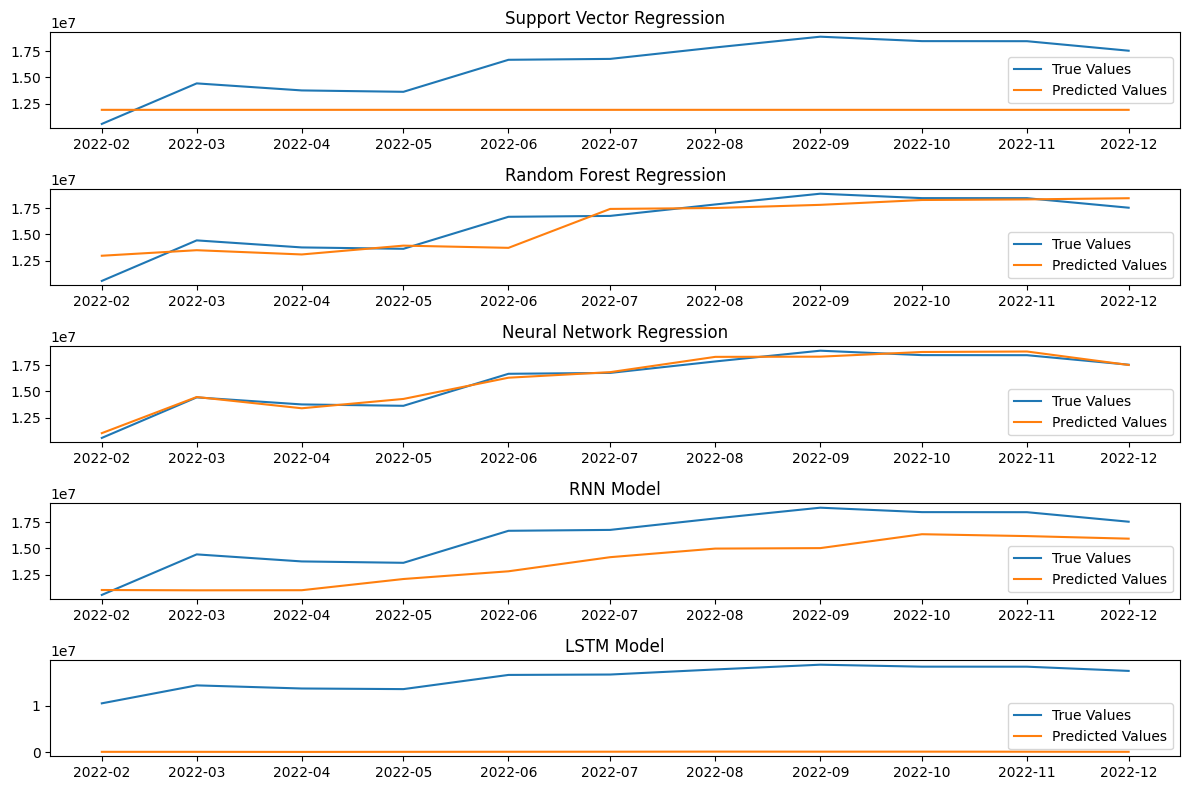

In [50]:
# Plot line charts for true and predicted values
plt.figure(figsize=(12, 8))

# Support Vector Regression
plt.subplot(5, 1, 1)
plt.plot(test_dates, y_test, label='True Values')
plt.plot(test_dates, svm_model.predict(X_test), label='Predicted Values')
plt.title('Support Vector Regression')
plt.legend()

# Random Forest Regression
plt.subplot(5, 1, 2)
plt.plot(test_dates, y_test, label='True Values')
plt.plot(test_dates, rf_model.predict(X_test), label='Predicted Values')
plt.title('Random Forest Regression')
plt.legend()

# Neural Network Regression
plt.subplot(5, 1, 3)
plt.plot(test_dates, y_test, label='True Values')
plt.plot(test_dates, nn_model.predict(X_test), label='Predicted Values')
plt.title('Neural Network Regression')
plt.legend()

# RNN
plt.subplot(5, 1, 4)
plt.plot(test_dates, y_test, label='True Values')
plt.plot(test_dates, rnn_model.predict(X_test_array), label='Predicted Values')
plt.title('RNN Model')
plt.legend()

# LSTM
plt.subplot(5, 1, 5)
plt.plot(test_dates, y_test, label='True Values')
plt.plot(test_dates, lstm_model.predict(X_test_array), label='Predicted Values')
plt.title('LSTM Model')
plt.legend()

plt.tight_layout()

plt.show()

In [51]:
pred_svr = pd.DataFrame(svm_model.predict(data_clean.iloc[:,1:]).flatten(),columns=['pred_svr'], index=data_clean.index)
pred_rf = pd.DataFrame(rf_model.predict(data_clean.iloc[:,1:]).flatten(),columns=['pred_rf'], index=data_clean.index)
pred_nn = pd.DataFrame(nn_model.predict(data_clean.iloc[:,1:]).flatten(),columns=['pred_nn'], index=data_clean.index)
pred_rnn = pd.DataFrame(rnn_model.predict(data_clean.iloc[:,1:].values).flatten(),columns=['pred_rnn'], index=data_clean.index)
pred_lstm = pd.DataFrame(lstm_model.predict(data_clean.iloc[:,1:].values).flatten(),columns=['pred_lstm'], index=data_clean.index)

pred_results = pd.concat([pred_svr, pred_rf, pred_nn, pred_rnn, pred_lstm, data_clean['target']], axis=1)

# Store results in a DataFrame
results_df = pd.DataFrame([evaluation_all('SVR', pred_results['target'], pred_results['pred_svr']),
                           evaluation_all('RF', pred_results['target'], pred_results['pred_rf']),
                           evaluation_all('MLP', pred_results['target'], pred_results['pred_nn']),
                           evaluation_all('RNN', pred_results['target'], pred_results['pred_rnn']),
                           evaluation_all('LSTM', pred_results['target'], pred_results['pred_lstm'])])
results_df.round(0)
results_df

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Model,AIC_train,BIC_train,R-squared_train,MAE_train,RMSE_train
0,SVR,3163.349389,3165.964509,-0.061839,4.599524e+06,6.263467e+06
1,RF,2751.114688,2753.729808,0.982074,5.203992e+05,8.138071e+05
2,MLP,2513.680512,2516.295632,0.998292,1.916069e+05,2.512144e+05
3,RNN,3038.105070,3040.720190,0.692734,2.677524e+06,3.369325e+06
4,LSTM,3335.024245,3337.639365,-4.811002,1.335673e+07,1.465248e+07


In [52]:
results_df.to_csv('output/evaluation_ml_model.csv')

results show that MLP or neural network perform the best based on RMSE and MSE, so that this 

Forecast ahaed

In [53]:
def forecast_new(latest, model, ar_order, diff_order, ma_order, month_ahaed = 1):
  # Make sure that the latest value of last series is not missing or 0
  i = 0
  while latest.iloc[-1]['target'] == 0:
    latest = latest.drop(latest.index[-1])
    i = i+1
  month_ahaed = i+month_ahaed

  # Forecasting new series
  for _ in range(month_ahaed):
    new_date = latest.index.max() + pd.DateOffset(months=1)
    new_row = pd.Series({'target': latest.loc[latest.index.max(), 'target']}, name=new_date)
    latest = pd.concat([latest, new_row.to_frame().T])

    last_data = generate_ar_ma_dataframe(latest['target'], ar_order, diff_order, ma_order,0)

    last_data = last_data.drop(columns='target')
    pred = model.predict(last_data)

    latest_index = latest.index.max()
    latest.loc[latest_index, 'target'] = pred[len(pred)-1]

  latest.iloc[0:len(latest)-month_ahaed, latest.columns.get_loc('target')] = np.nan
  return latest

In [54]:
month_ahaed = 6
latest = pd.DataFrame({'target': y_test}, index=test_dates)
pred_new = forecast_new(latest, nn_model, 7, 0, 3, month_ahaed)

y_test_original = pd.DataFrame(y_test).rename(columns={'target': 'y_test'})
y_test_pred_original = pd.DataFrame(svm_model.predict(X_test),index=test_dates, columns=['y_test_pred'])

pred_new = pd.concat([pred_new, y_test_original, y_test_pred_original], axis=1)
pred_new['y_test_pred'].fillna(pred_new['target'], inplace=True)

# **Multi Model - Time Series and Regression**

The application of multimodel time series analysis combined with linear regression is a powerful approach to identifying significant patterns within data. Time series methods like Prophet are used for forecasting by capturing trends, seasonality, and holidays. Prophet is particularly effective for handling missing data and large datasets with complex seasonal effects, making it a robust choice for time series forecasting. By integrating Prophet, we can gain insights into long-term trends and seasonal variations in the data.

In addition to time series analysis, linear regression techniques, such as Ridge Regression and traditional Linear Regression, are employed to refine predictions and improve model accuracy. Ridge Regression helps to address multicollinearity by adding a penalty term to the regression, which stabilizes the model and prevents overfitting. This is especially useful when dealing with highly correlated predictors. Linear Regression, on the other hand, provides a straightforward approach to understanding the relationship between variables. By combining these methodologies, we enhance our ability to capture and interpret significant patterns, resulting in more accurate and reliable forecasts.

RMSE: 451649.2724486969
R-squared: 0.9873682025938042


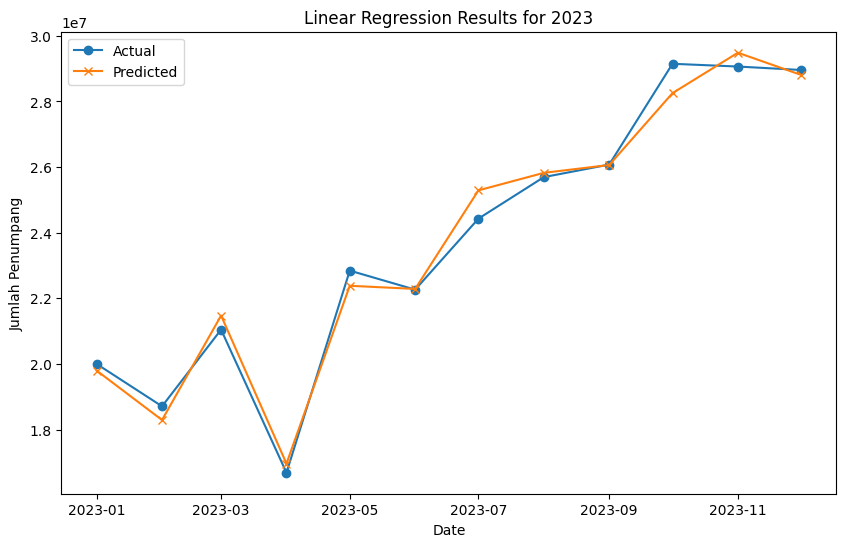

In [55]:
data_2023 = data_cleaned[data_cleaned.index >= '2023-01-01']

# Extract date features
data_2023['month'] = data_2023.index.month
data_2023['year'] = data_2023.index.year

# Define features and target
X = data_2023[['jumlah_perjalanan_mrt', 'jumlah_perjalanan_lrt', 'jumlah_armada_tj', 'jumlah_penumpang_lrt', 'jumlah_penumpang_mrt', 'month', 'year']]
y = data_2023['jumlah_penumpang']

# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

# Evaluate the model
rmse = mean_squared_error(y, predictions, squared=False)
r2 = r2_score(y, predictions)

print('RMSE:', rmse)
print('R-squared:', r2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', marker='o')
plt.plot(y.index, predictions, label='Predicted', marker='x')
plt.legend()
plt.title('Linear Regression Results for 2023')
plt.xlabel('Date')
plt.ylabel('Jumlah Penumpang')
plt.show()

Predictions for 2024 (January to May):
Date: 2024-01-01, Prediction: 27301017.165845722
Date: 2024-02-01, Prediction: 24479063.37620379
Date: 2024-03-01, Prediction: 26410496.23622197
Date: 2024-04-01, Prediction: 24789408.988701113
Date: 2024-05-01, Prediction: 27812637.23522634


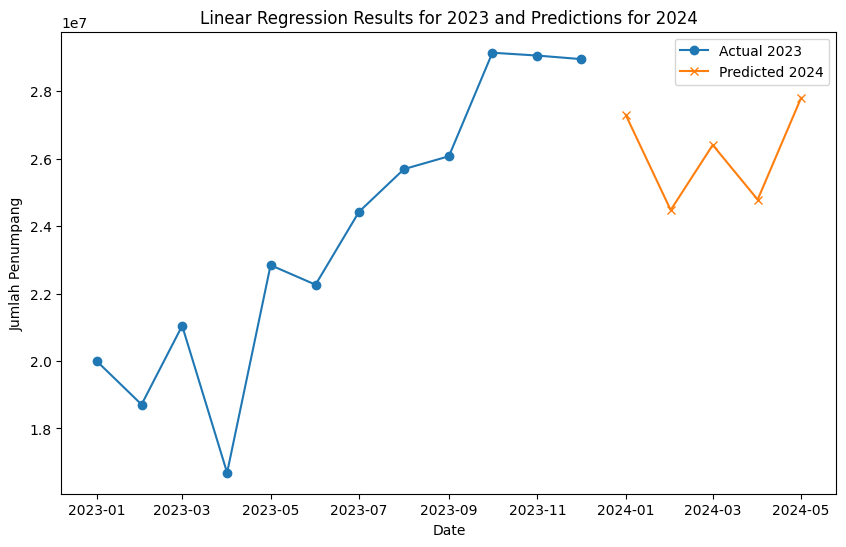

In [56]:
# Filter data for 2024 (Januari-Mei)
data_2024 = data_all[data_all.index >= '2024-01-01']
data_2024['month'] = data_2024.index.month
data_2024['year'] = data_2024.index.year

# Define features for prediction
X_2024 = data_2024[['jumlah_perjalanan_mrt', 'jumlah_perjalanan_lrt', 'jumlah_armada_tj', 'jumlah_penumpang_lrt', 'jumlah_penumpang_mrt', 'month', 'year']]

# Make predictions
predictions_2024 = model.predict(X_2024)

# Display the predictions
print("Predictions for 2024 (January to May):")
for date, prediction in zip(data_2024.index, predictions_2024):
    print(f"Date: {date.strftime('%Y-%m-%d')}, Prediction: {prediction}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data_2023.index, y, label='Actual 2023', marker='o')
plt.plot(data_2024.index, predictions_2024, label='Predicted 2024', marker='x')
plt.legend()
plt.title('Linear Regression Results for 2023 and Predictions for 2024')
plt.xlabel('Date')
plt.ylabel('Jumlah Penumpang')
plt.show()

In [57]:
prediction = pd.DataFrame()
prediction['ds'] = pd.to_datetime(data_2024.index)
prediction['y']= predictions_2024
prediction.head()

,ds,y
0,2024-01-01,2.730102e+07
1,2024-02-01,2.447906e+07
2,2024-03-01,2.641050e+07
3,2024-04-01,2.478941e+07
4,2024-05-01,2.781264e+07


In [58]:
sys.path.append(os.path.join(os.getcwd(), 'script'))
from prophet_v1 import main_prophet_v1
from prophet_v2 import main_prophet_v2

06:11:22 - cmdstanpy - INFO - Chain [1] start processing
06:11:22 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 876294.6733302065


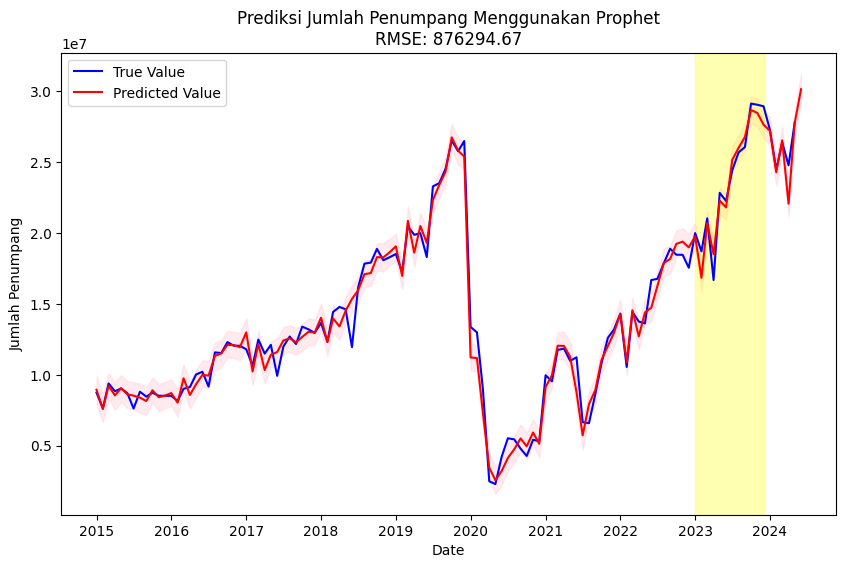

In [59]:
filepath = 'data/training_jumlah_penumpang_tj.csv'
prediction_v1 = main_prophet_v1(filepath, 1, prediction)

06:11:23 - cmdstanpy - INFO - Chain [1] start processing
06:11:25 - cmdstanpy - INFO - Chain [1] done processing
06:11:25 - cmdstanpy - INFO - Chain [1] start processing
06:12:33 - cmdstanpy - INFO - Chain [1] done processing


Overall RMSE: 893354.325173124


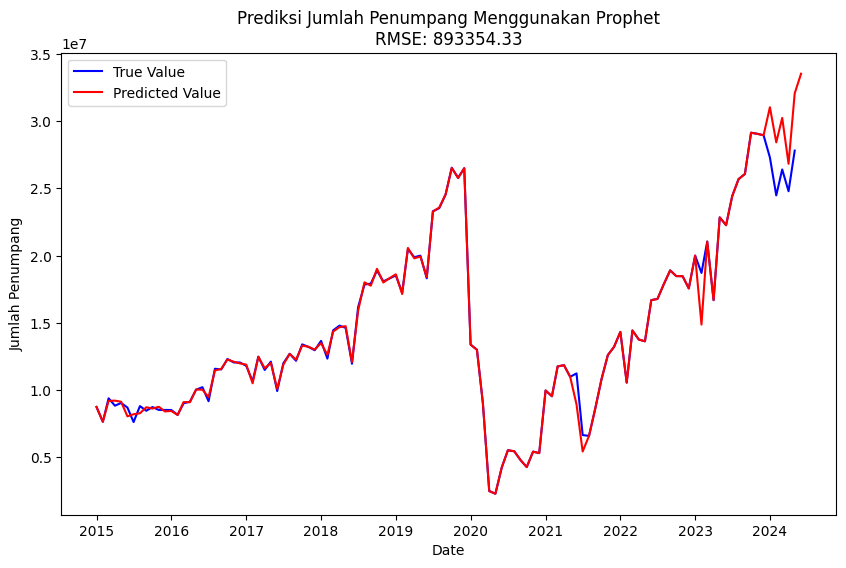

In [60]:
prediction_v2 = main_prophet_v2(filepath, 1, prediction)

In [61]:
prediction_v1.to_csv('output/prophet_v1.csv')
prediction_v2.to_csv('output/prophet_v2.csv')

In [62]:
testing_v1 = pd.DataFrame({
    'id': range(1, 7),
    'jumlah_penumpang': prediction_v1.iloc[-6:, 0].values
})

testing_v1

,id,jumlah_penumpang
0,1,27229081.0
1,2,24299589.0
2,3,26553745.0
3,4,22073657.0
4,5,27773127.0
5,6,30159359.0


In [63]:
testing_v2 = pd.DataFrame({
    'id': range(1, 7),
    'jumlah_penumpang': prediction_v2.iloc[-6:, 0].values
})

testing_v2

,id,jumlah_penumpang
0,1,31042512.0
1,2,28425476.0
2,3,30246500.0
3,4,26833895.0
4,5,32072436.0
5,6,33533940.0


In [64]:
testing_v1.to_csv('output/testing_pred_2.csv')
testing_v2.to_csv('output/testing_pred_4.csv')

In [65]:
end_time = time.time()
execution_time = end_time - start_time
print(f'Total execution time: {execution_time:.2f} seconds')

def get_size(start_path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

size_in_bytes = get_size()
size_in_megabytes = size_in_bytes / (1024 * 1024)
print(f'Total storage size: {size_in_megabytes:.2f} MB')

Total execution time: 114.49 seconds
Total storage size: 4.12 MB
